In [1]:
# Librerías básicas
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline

import seaborn as sns
sns.set()

# El módulo Statsmodels

Statsmodels es un módulo de Python que ofrece clases y funciones de varios modelos estadísticos, así como pruebas de hipótesis 
y análisis exploratorio de datos. La documentación se encuentra en <a href='https://www.statsmodels.org/stable/index.html'>statsmodels.org</a>. 

In [2]:
import statsmodels.graphics.tsaplots as sgt 
import statsmodels.tsa.stattools as sts 
from statsmodels.tsa.seasonal import seasonal_decompose

# Fuentes de datos interesantes

## API de Yahoo finance

Yahoo Finance tiene una API que permite descargar información financiera para realizar análisis. La página web original de la documentación ya no existe. Sin embargo, existen algunas páginas de documentación no oficial como <a href= 'https://github.com/mxbi/yahoo-finance-api.git'> este repositorio en GitHub, </a> o <a href='https://python-yahoofinance.readthedocs.io/en/latest/api.html'> esta página de documentación the ReadTheDocs </a>.

In [3]:
# Instalación de yfinance
%pip install yfinance

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
# Se importa la librería yfinance
import yfinance

In [5]:
# Se descargan los datos S&P500 y Nikkei225
df_yfinance_raw = yfinance.download(tickers = "^GSPC ^N225", #Las series de tiempo de interés - (en nuestro caso, S&P500 y NIKKEI225)
                              start = "1994-01-07", #Fecha inicial
                              end = "2024-08-27", #Fecha final
                              interval = "1d", #Frecuencia.
                              group_by = 'ticker', #Criterio de agrupación. Usualmente "ticker"
                              auto_adjust = True#,  
                              #threads = True
                               ) #. 

[*********************100%***********************]  2 of 2 completed


In [6]:
df_yfinance_raw.head()

Ticker                          ^GSPC                                      \
Price                            Open        High         Low       Close   
Date                                                                        
1994-01-07 00:00:00+00:00  467.089996  470.260010  467.029999  469.899994   
1994-01-10 00:00:00+00:00  469.899994  475.269989  469.549988  475.269989   
1994-01-11 00:00:00+00:00  475.269989  475.279999  473.269989  474.130005   
1994-01-12 00:00:00+00:00  474.130005  475.059998  472.140015  474.170013   
1994-01-13 00:00:00+00:00  474.170013  474.170013  471.799988  472.470001   

Ticker                                         ^N225                \
Price                           Volume          Open          High   
Date                                                                 
1994-01-07 00:00:00+00:00  324920000.0  17842.980469  18131.410156   
1994-01-10 00:00:00+00:00  319490000.0  18186.519531  18567.060547   
1994-01-11 00:00:00+00:00  305490000.0  18481.849609  18671.669922   
1994-01-12 00:00:00+00:00  310690000.0  18447.339844  18807.080078   
1994-01-13 00:00:00+00:00  277970000.0  18770.380859  18823.380859   

Ticker                                                        
Price                               Low         Close Volume  
Date                                                          
1994-01-07 00:00:00+00:00  17787.480469  18124.009766    0.0  
1994-01-10 00:00:00+00:00  18186.519531  18443.439453    0.0  
1994-01-11 00:00:00+00:00  18373.039062  18485.250000    0.0  
1994-01-12 00:00:00+00:00  18301.929688  18793.880859    0.0  
1994-01-13 00:00:00+00:00  18548.750000  18577.259766    0.0

In [7]:
# Se crea una copia para modificar
df_yfinance = df_yfinance_raw.copy()

In [8]:
# Se agregan columnas para el nivel de cierre de los índices S&P500 y Nikkei255
df_yfinance['spx'] = df_yfinance['^GSPC'].Close
df_yfinance['nikkei'] = df_yfinance['^N225'].Close

In [9]:
#f_comp = df_comp.iloc[1:] # Removing the first elements, since we always start 1 period before the first, due to time zone differences of closing prices
del df_yfinance['^N225'] # Se retiran los grupos de columnas '^N225' y '^GSPC'
del df_yfinance['^GSPC']
df_yfinance=df_yfinance.asfreq('b') # Se establece la frecuencia de los datos
df_yfinance=df_yfinance.fillna(method='ffill') # Se rellenan los datos faltantes con el método ffill que usa el último valor válido

In [10]:
df_yfinance.head()

Ticker,spx,nikkei
Price,,
Date,,
1994-01-07 00:00:00+00:00,469.899994,18124.009766
1994-01-10 00:00:00+00:00,475.269989,18443.439453
1994-01-11 00:00:00+00:00,474.130005,18485.250000
1994-01-12 00:00:00+00:00,474.170013,18793.880859
1994-01-13 00:00:00+00:00,472.470001,18577.259766


In [11]:
df_yfinance.columns

MultiIndex([(   'spx', ''),
            ('nikkei', '')],
           names=['Ticker', 'Price'])

In [12]:
df_yfinance.columns=['spx','nikkei']

In [13]:
df_yfinance.columns

Index(['spx', 'nikkei'], dtype='object')

In [14]:
df_yfinance.head() 

,spx,nikkei
Date,,
1994-01-07 00:00:00+00:00,469.899994,18124.009766
1994-01-10 00:00:00+00:00,475.269989,18443.439453
1994-01-11 00:00:00+00:00,474.130005,18485.250000
1994-01-12 00:00:00+00:00,474.170013,18793.880859
1994-01-13 00:00:00+00:00,472.470001,18577.259766


In [15]:
df_yfinance.tail() # Making sure of the last day we're including in the series

,spx,nikkei
Date,,
2024-08-20 00:00:00+00:00,5597.120117,38062.921875
2024-08-21 00:00:00+00:00,5620.850098,37951.800781
2024-08-22 00:00:00+00:00,5570.640137,38211.011719
2024-08-23 00:00:00+00:00,5634.609863,38364.269531
2024-08-26 00:00:00+00:00,5616.839844,38110.218750


In [16]:
#df_comp.date = pd.to_datetime(df_comp.date, dayfirst = True)
#df_comp.set_index("date", inplace=True)
df_yfinance=df_yfinance.asfreq('b')
df_yfinance=df_yfinance.fillna(method='ffill')

In [17]:
df_yfinance.head()

,spx,nikkei
Date,,
1994-01-07 00:00:00+00:00,469.899994,18124.009766
1994-01-10 00:00:00+00:00,475.269989,18443.439453
1994-01-11 00:00:00+00:00,474.130005,18485.250000
1994-01-12 00:00:00+00:00,474.170013,18793.880859
1994-01-13 00:00:00+00:00,472.470001,18577.259766


## Algunos archivos csv con datos

En <a href='https://github.com/jbrownlee/Datasets.git'>este repositorio de GitHub</a> se encuentran muchos archivos .csv con datos apropiados para ejercicios de aprendizaje de máquina y series de tiempo. En este notebook utilizaremos el archivo 'airline_passengers.csv'.

In [18]:
df_airline = pd.read_csv('airline_passengers.csv',index_col='Month',parse_dates=True)

In [19]:
df_airline.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


## Datos que vienen con la librería statsmodels
La librería <a href='https://www.statsmodels.org/stable/index.html'>statsmodels</a> tiene varios conjuntos de datos incorporados.
En este notebook, utilizaremos el dataset 'macrodata', que trae datos macroeconómicos de EEUU.

In [20]:
#import pandas as pd
import statsmodels.api as sm
df_macrodata = sm.datasets.macrodata.load_pandas().data
df_macrodata.index = pd.Index(sm.tsa.datetools.dates_from_range('1959Q1', '2009Q3'))
print(sm.datasets.macrodata.NOTE)

::
    Number of Observations - 203

    Number of Variables - 14

    Variable name definitions::

        year      - 1959q1 - 2009q3
        quarter   - 1-4
        realgdp   - Real gross domestic product (Bil. of chained 2005 US$,
                    seasonally adjusted annual rate)
        realcons  - Real personal consumption expenditures (Bil. of chained
                    2005 US$, seasonally adjusted annual rate)
        realinv   - Real gross private domestic investment (Bil. of chained
                    2005 US$, seasonally adjusted annual rate)
        realgovt  - Real federal consumption expenditures & gross investment
                    (Bil. of chained 2005 US$, seasonally adjusted annual rate)
        realdpi   - Real private disposable income (Bil. of chained 2005
                    US$, seasonally adjusted annual rate)
        cpi       - End of the quarter consumer price index for all urban
                    consumers: all items (1982-84 = 100, seasonally adju

In [21]:
df_macrodata.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
1959-03-31,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1959-06-30,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
1959-09-30,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
1959-12-31,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
1960-03-31,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


## Datos de simulados de ventas

In [22]:
df_ventas = pd.read_excel('Datos_clase_1.xlsx',index_col = 'Fecha', parse_dates = True)

# Diferenciación

## Diferenciación de primer orden

In [23]:
df_ventas['d1a']=df_ventas['Ventas']-df_ventas['Ventas'].shift(1)

In [24]:
df_ventas.head()

,Ventas,d1a
Fecha,,
2023-01-01,12900.965726,NaN
2023-01-02,14962.847415,2061.881689
2023-01-03,17328.133221,2365.285806
2023-01-04,19080.675831,1752.542610
2023-01-05,16665.614172,-2415.061659


In [25]:
df_ventas['d1b']=df_ventas['Ventas'].diff()

In [26]:
df_ventas.head()

,Ventas,d1a,d1b
Fecha,,,
2023-01-01,12900.965726,NaN,NaN
2023-01-02,14962.847415,2061.881689,2061.881689
2023-01-03,17328.133221,2365.285806,2365.285806
2023-01-04,19080.675831,1752.542610,1752.542610
2023-01-05,16665.614172,-2415.061659,-2415.061659


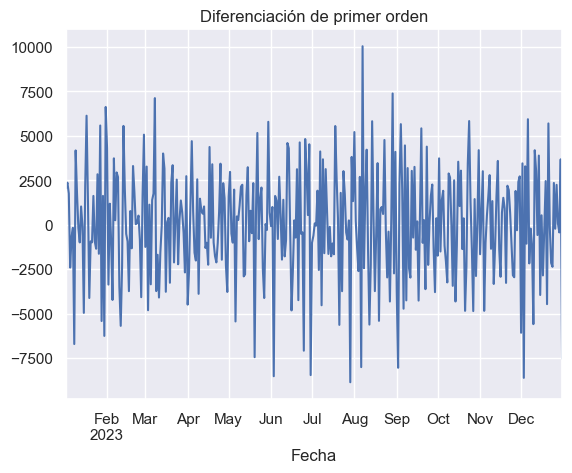

In [27]:
df_ventas['d1b'].plot(title="Diferenciación de primer orden").autoscale(axis='x',tight=True);

## Diferenciación de segundo orden

In [28]:
df_ventas['d2'] = df_ventas['d1a'].diff()

In [29]:
df_ventas.head()

,Ventas,d1a,d1b,d2
Fecha,,,,
2023-01-01,12900.965726,NaN,NaN,NaN
2023-01-02,14962.847415,2061.881689,2061.881689,NaN
2023-01-03,17328.133221,2365.285806,2365.285806,303.404117
2023-01-04,19080.675831,1752.542610,1752.542610,-612.743196
2023-01-05,16665.614172,-2415.061659,-2415.061659,-4167.604269


# Ruido blanco

In [30]:
wn = np.random.normal(loc = df_yfinance['spx'].mean(), scale = df_yfinance['spx'].std(), size = len(df_yfinance))

In [31]:
df_yfinance['wn']=wn

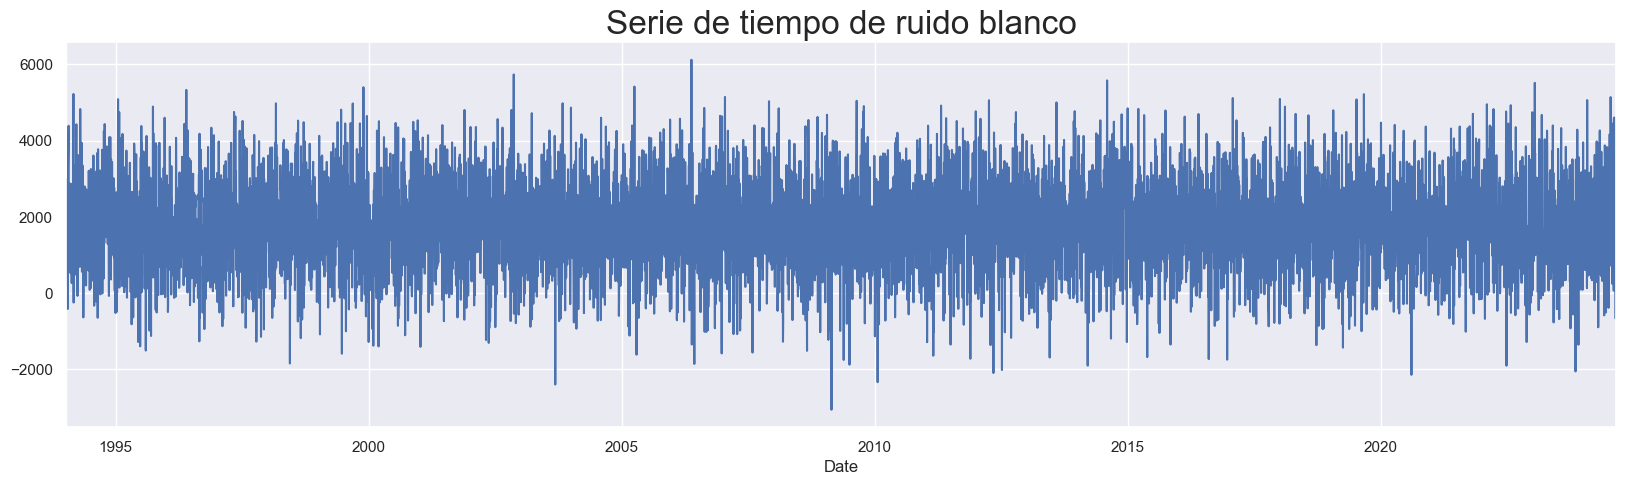

In [32]:
df_yfinance.wn.plot(figsize = (20,5))
plt.title("Serie de tiempo de ruido blanco", size= 24)
plt.show()

# Caminata aleatoria

In [33]:
steps = np.random.choice([-10, 10], size = len(df_yfinance))

In [34]:
steps[0]=0

In [35]:
rw = df_yfinance['spx'].mean()+np.cumsum(steps)

In [36]:
df_yfinance['rw']=rw

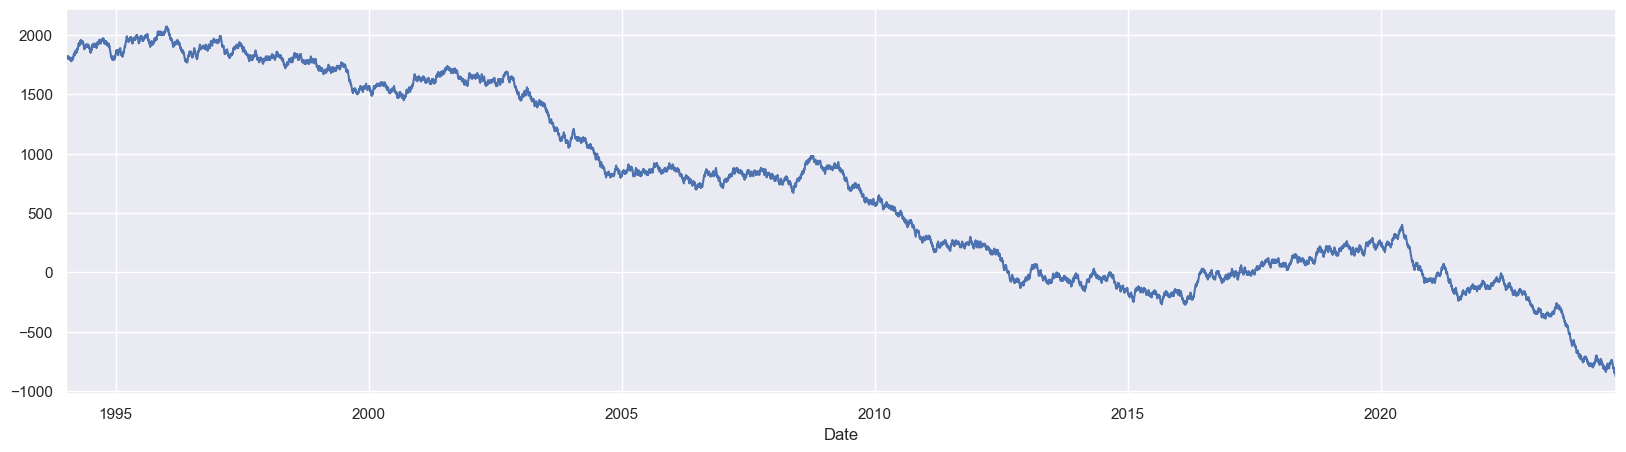

In [37]:
df_yfinance['rw'].plot(figsize = (20,5));

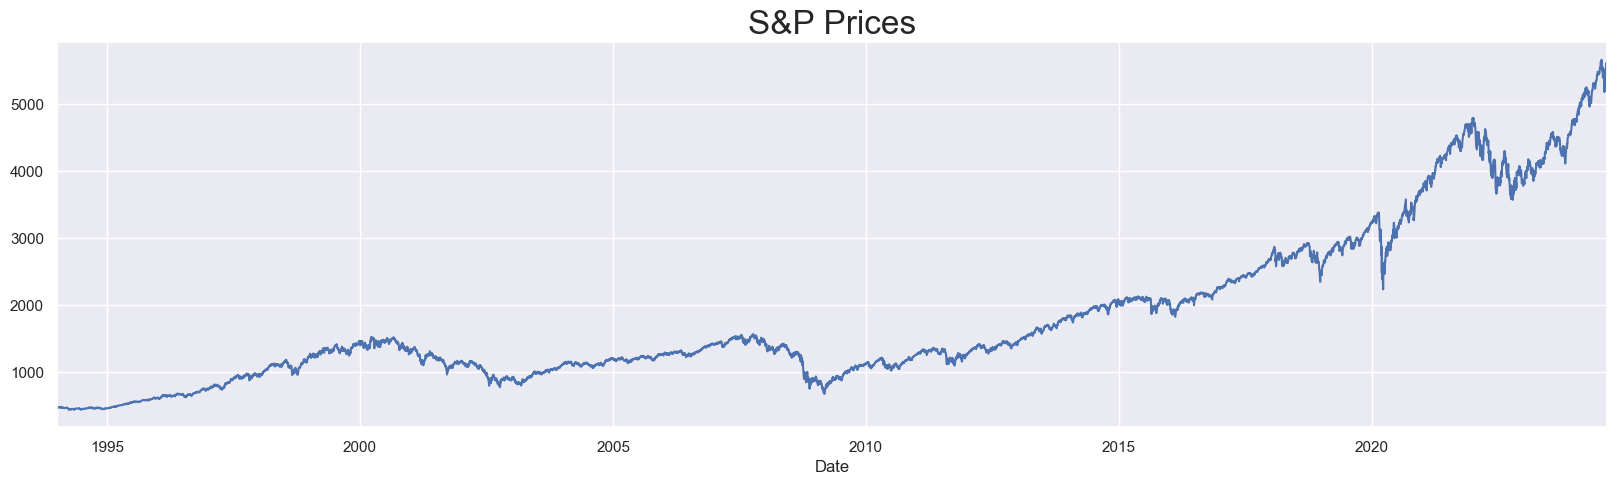

In [38]:
df_yfinance['spx'].plot(figsize=(20,5))
plt.title("S&P Prices", size = 24)
#plt.ylim(0,2300)
plt.show()

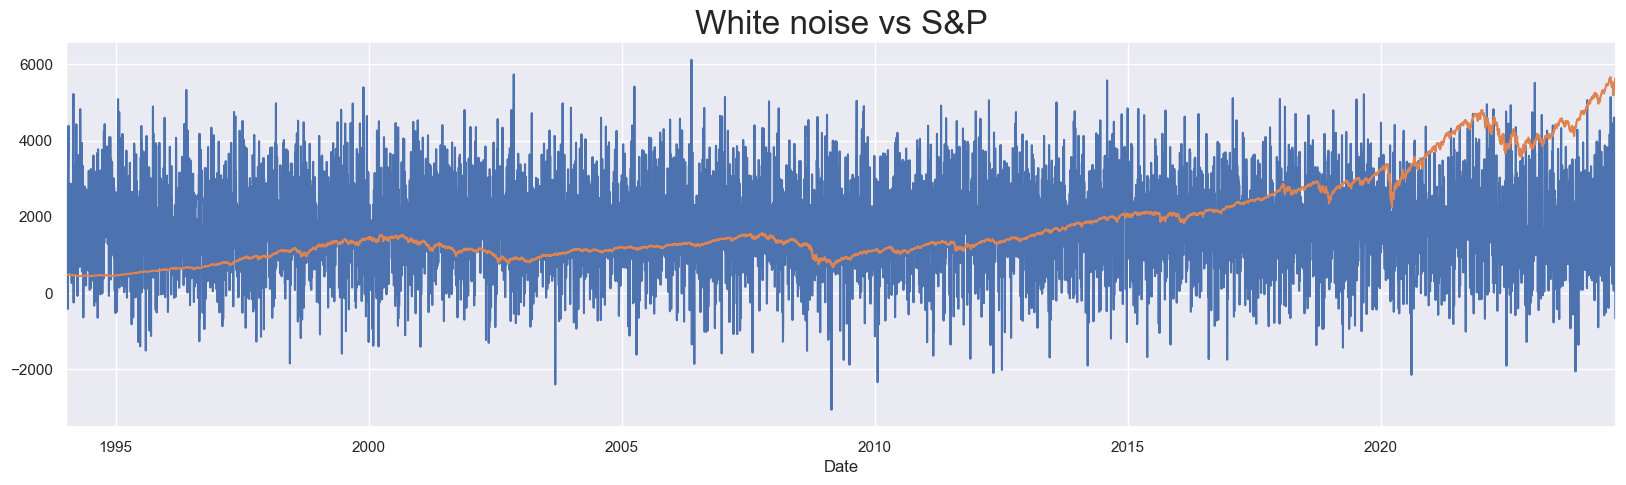

In [39]:
df_yfinance.wn.plot(figsize = (20,5))
df_yfinance['spx'].plot()
plt.title("White noise vs S&P", size = 24)
plt.show()

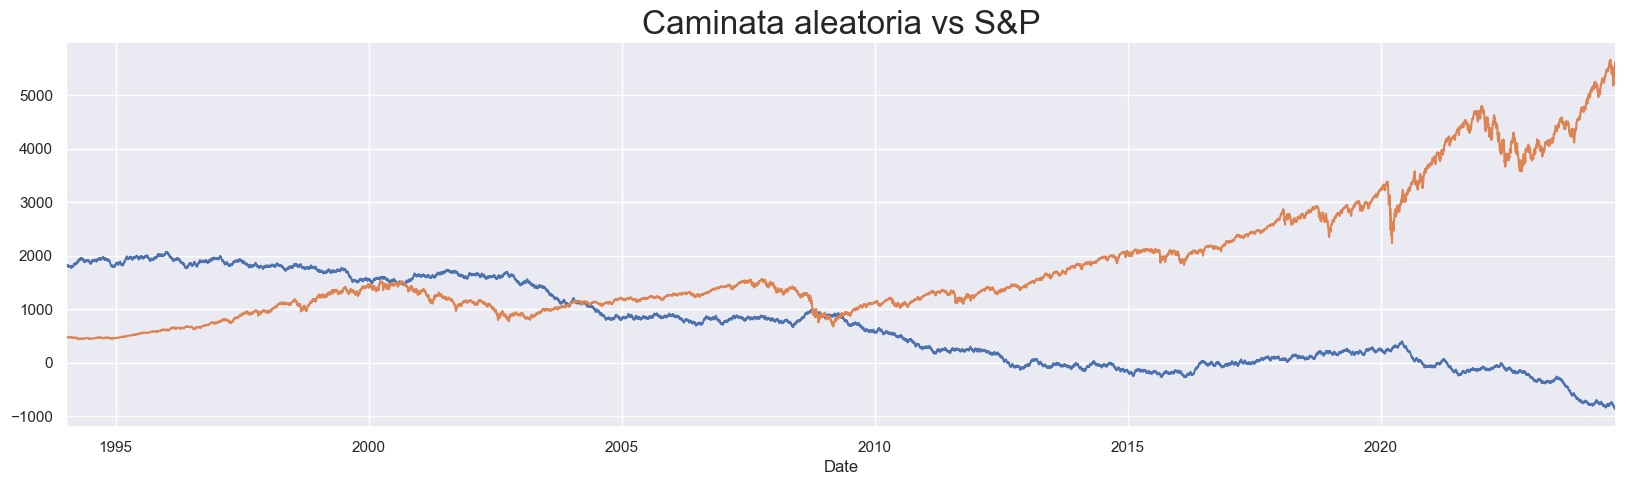

In [40]:
df_yfinance.rw.plot(figsize = (20,5))
df_yfinance['spx'].plot()
plt.title("Caminata aleatoria vs S&P", size = 24)
plt.show()

# Descomposición de Hodrick-Prescott

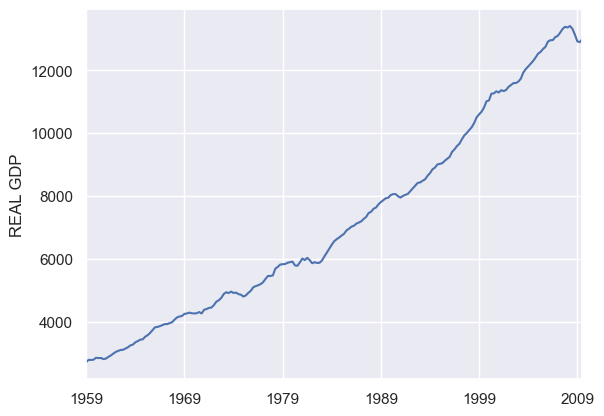

In [41]:
ax = df_macrodata['realgdp'].plot()
ax.autoscale(axis='x',tight=True)
ax.set(ylabel='REAL GDP');

In [42]:
from statsmodels.tsa.filters.hp_filter import hpfilter

# Se separa la descomposición
gdp_cycle, gdp_trend = hpfilter(df_macrodata['realgdp'], lamb=1600)

In [43]:
#

spx_cycle, spx_trend = hpfilter(df_yfinance['spx'], lamb=10000000)

In [44]:
gdp_cycle.head()

1959-03-31    39.511915
1959-06-30    80.088532
1959-09-30    48.875455
1959-12-31    30.591933
1960-03-31    64.882667
Name: realgdp_cycle, dtype: float64

In [45]:
df_macrodata['trend'] = gdp_trend

In [46]:
df_yfinance['trend'] = spx_trend

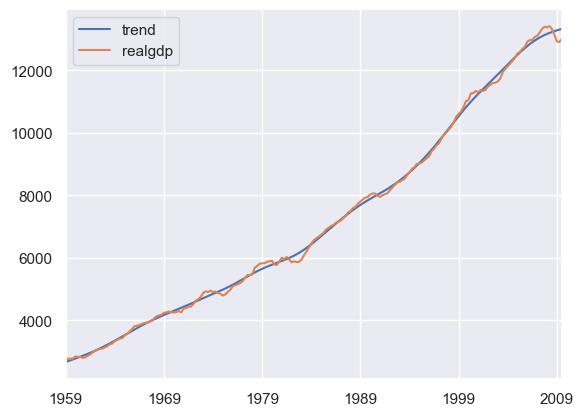

In [47]:
df_macrodata[['trend','realgdp']].plot().autoscale(axis='x',tight=True);

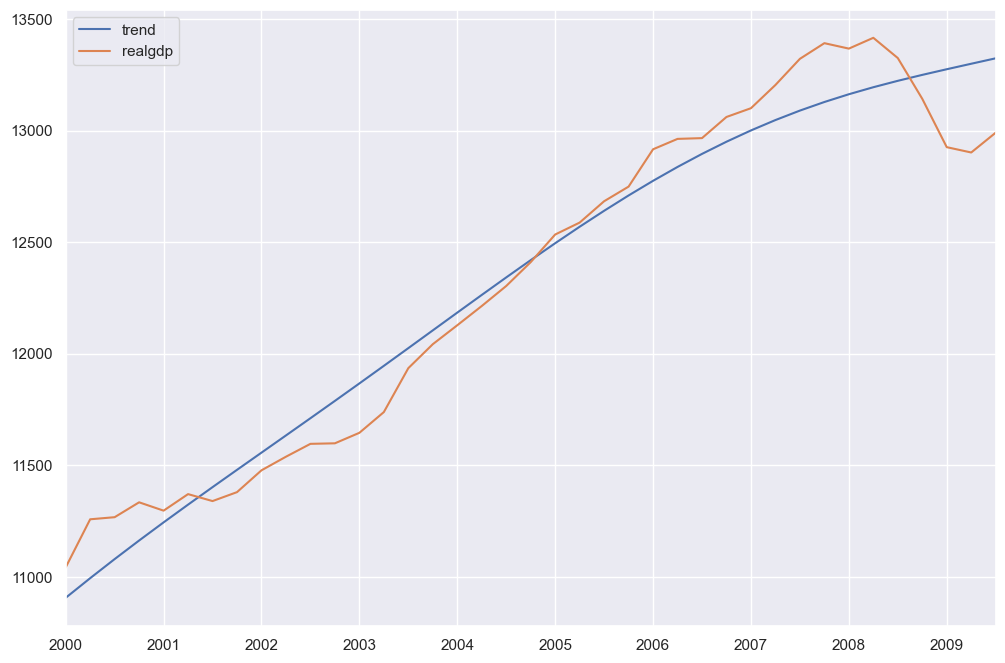

In [48]:
df_macrodata[['trend','realgdp']]['2000-03-31':].plot(figsize=(12,8)).autoscale(axis='x',tight=True);

In [49]:
df_macrodata['cycle'] = gdp_cycle

In [50]:
df_yfinance['cycle'] = spx_cycle

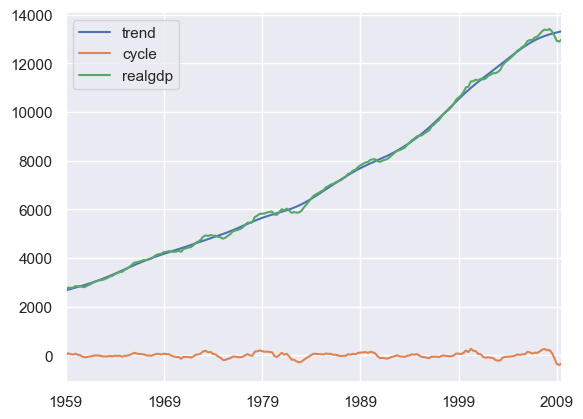

In [51]:
df_macrodata[['trend','cycle','realgdp']].plot().autoscale(axis='x',tight=True);

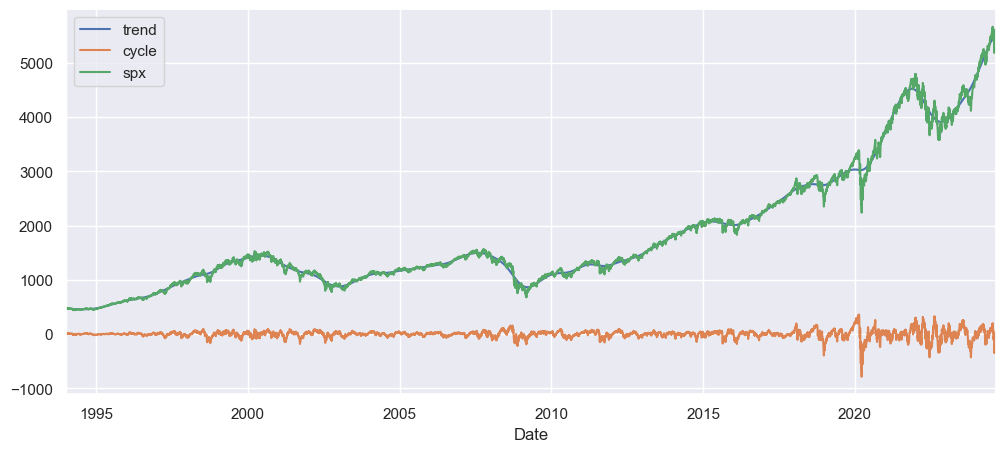

In [52]:
df_yfinance[['trend','cycle','spx']].plot(figsize=(12,5)).autoscale(axis='x',tight=True);

# Descomposición ETS (Error-Trend-Seasonality)

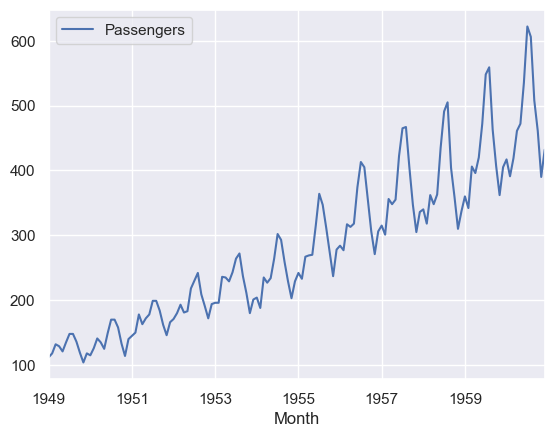

In [53]:
df_airline.plot();

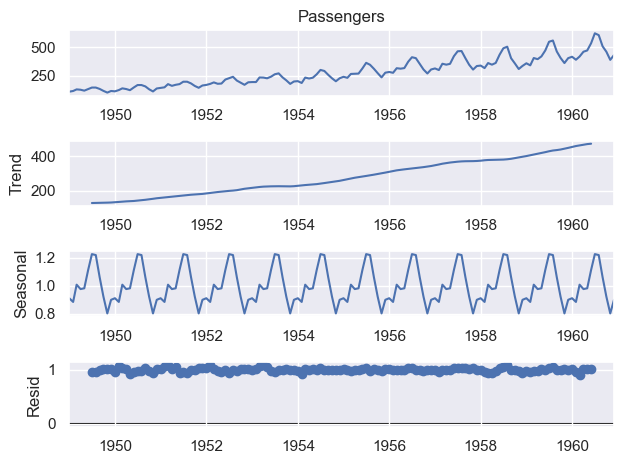

In [54]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df_airline['Passengers'], model='multiplicative')  # model='mul' also works
result.plot();

In [108]:
df_trend=result.resid

In [109]:
df_trend.head(20)

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01    0.951664
1949-08-01    0.953401
1949-09-01    1.002220
1949-10-01    1.004028
1949-11-01    1.006270
1949-12-01    1.011812
1950-01-01    0.962603
1950-02-01    1.071467
1950-03-01    1.037447
1950-04-01    1.014048
1950-05-01    0.926903
1950-06-01    0.965041
1950-07-01    0.983557
1950-08-01    0.973372
Name: resid, dtype: float64

# SMA (Simple Moving Average)
Es la media móvil que se calcula con los cálculos de ventana móvil

In [55]:
df_airline['6-month-SMA'] = df_airline['Passengers'].rolling(window=6).mean()
df_airline['12-month-SMA'] = df_airline['Passengers'].rolling(window=12).mean()

In [56]:
df_airline.head(15)

,Passengers,6-month-SMA,12-month-SMA
Month,,,
1949-01-01,112,NaN,NaN
1949-02-01,118,NaN,NaN
1949-03-01,132,NaN,NaN
1949-04-01,129,NaN,NaN
1949-05-01,121,NaN,NaN
1949-06-01,135,124.500000,NaN
1949-07-01,148,130.500000,NaN
1949-08-01,148,135.500000,NaN
1949-09-01,136,136.166667,NaN


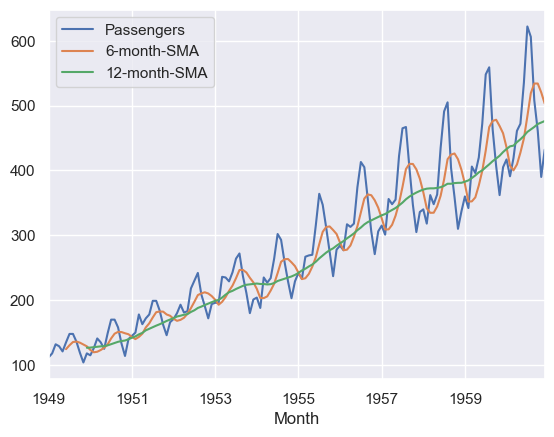

In [57]:
df_airline.plot();

# EWMA Exponentially Weighted Moving Average

In [58]:
df_airline['EWMA12'] = df_airline['Passengers'].ewm(span=12,adjust=False).mean()

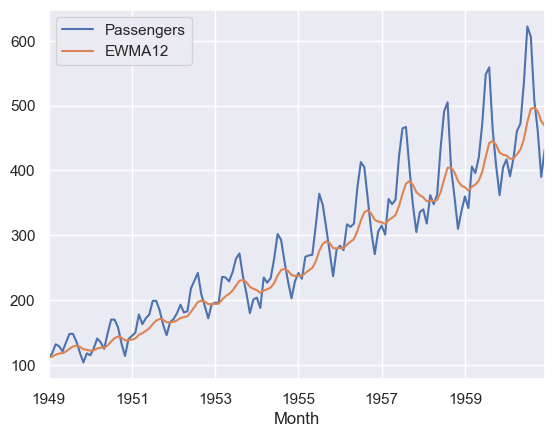

In [59]:
df_airline[['Passengers','EWMA12']].plot();

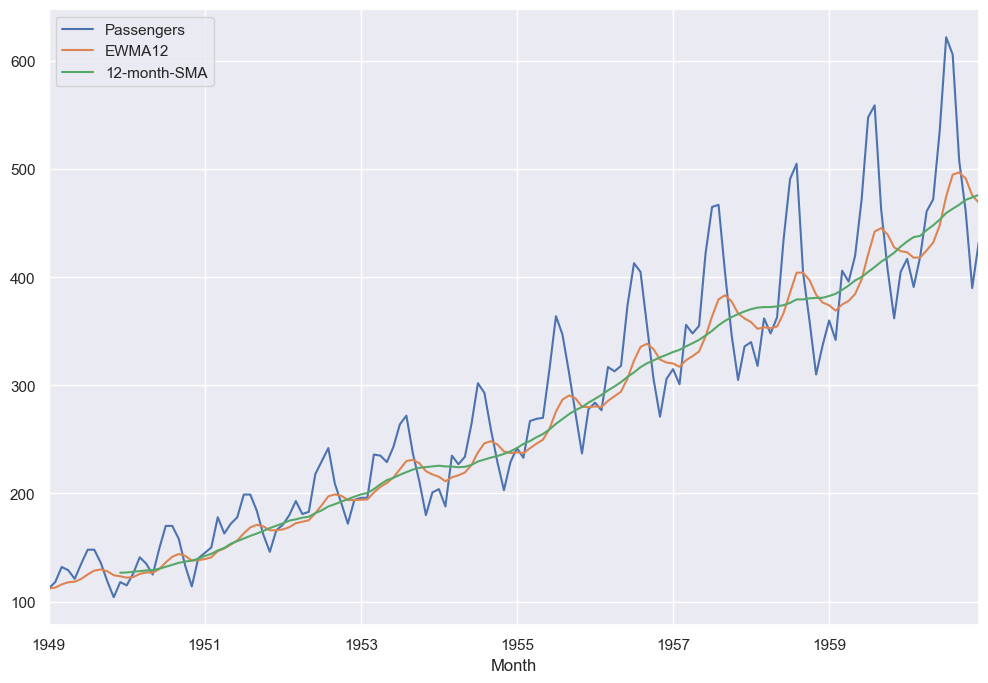

In [60]:
df_airline[['Passengers','EWMA12','12-month-SMA']].plot(figsize=(12,8)).autoscale(axis='x',tight=True);

# Métodos de Holt-Winters

## SES (Simple Exponential Smooting)

In [61]:
# df_airline.index.freq = 'MS'

In [62]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

span = 12
alpha = 2/(span+1)

df_airline['EWMA12'] = df_airline['Passengers'].ewm(alpha=alpha,adjust=False).mean()
df_airline['SES12']=SimpleExpSmoothing(df_airline['Passengers']).fit(smoothing_level=alpha,optimized=False).fittedvalues.shift(-1)
df_airline.head()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


,Passengers,6-month-SMA,12-month-SMA,EWMA12,SES12
Month,,,,,
1949-01-01,112,NaN,NaN,112.000000,112.000000
1949-02-01,118,NaN,NaN,112.923077,112.923077
1949-03-01,132,NaN,NaN,115.857988,115.857988
1949-04-01,129,NaN,NaN,117.879836,117.879836
1949-05-01,121,NaN,NaN,118.359861,118.359861


## DES (Double Exponential Smoothing)

In [63]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

df_airline['DESadd12'] = ExponentialSmoothing(df_airline['Passengers'], trend='add').fit().fittedvalues.shift(-1)
df_airline.head()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


,Passengers,6-month-SMA,12-month-SMA,EWMA12,SES12,DESadd12
Month,,,,,,
1949-01-01,112,NaN,NaN,112.000000,112.000000,114.102394
1949-02-01,118,NaN,NaN,112.923077,112.923077,120.040657
1949-03-01,132,NaN,NaN,115.857988,115.857988,134.001539
1949-04-01,129,NaN,NaN,117.879836,117.879836,131.085845
1949-05-01,121,NaN,NaN,118.359861,118.359861,123.110263


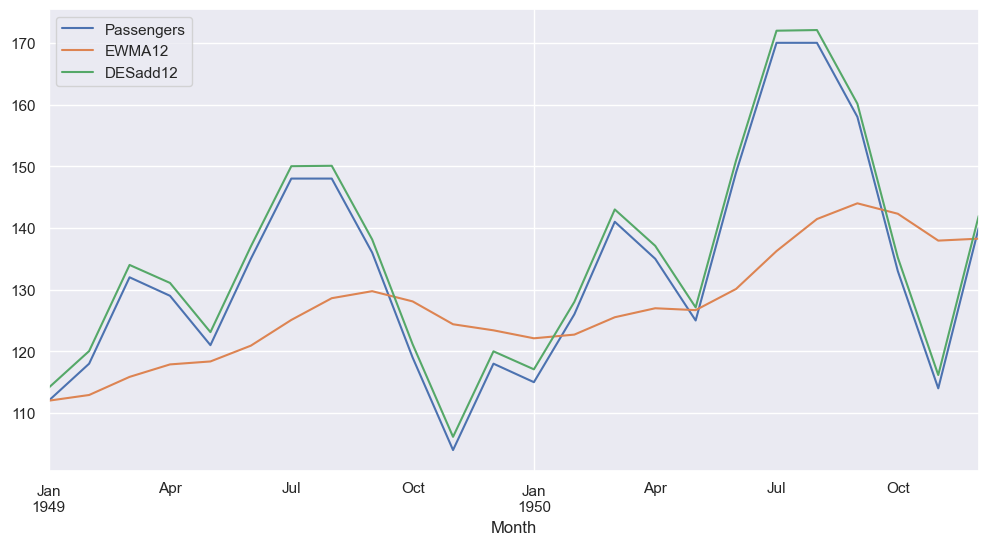

In [64]:
df_airline[['Passengers','EWMA12','DESadd12']].iloc[:24].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

In [65]:
df_airline['DESmul12'] = ExponentialSmoothing(df_airline['Passengers'], trend='mul').fit().fittedvalues.shift(-1)
df_airline.head()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


,Passengers,6-month-SMA,12-month-SMA,EWMA12,SES12,DESadd12,DESmul12
Month,,,,,,,
1949-01-01,112,NaN,NaN,112.000000,112.000000,114.102394,113.990701
1949-02-01,118,NaN,NaN,112.923077,112.923077,120.040657,120.031669
1949-03-01,132,NaN,NaN,115.857988,115.857988,134.001539,134.235979
1949-04-01,129,NaN,NaN,117.879836,117.879836,131.085845,131.270786
1949-05-01,121,NaN,NaN,118.359861,118.359861,123.110263,123.156267


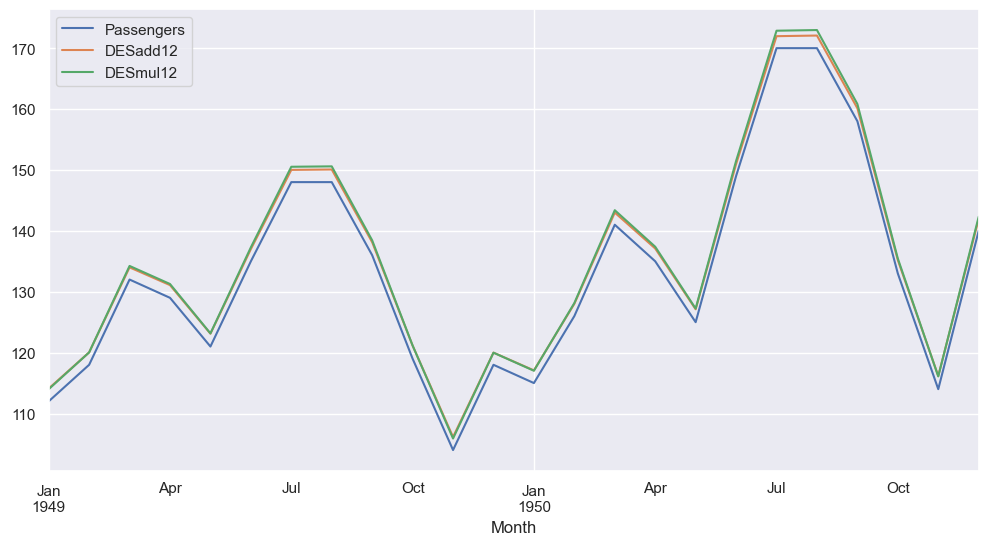

In [66]:
df_airline[['Passengers','DESadd12','DESmul12']].iloc[:24].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

## TES (Triple Exponential Smoothing)

In [67]:
df_airline['TESadd12'] = ExponentialSmoothing(df_airline['Passengers'],trend='add',seasonal='add',seasonal_periods=12).fit().fittedvalues
df_airline.head()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


,Passengers,6-month-SMA,12-month-SMA,EWMA12,SES12,DESadd12,DESmul12,TESadd12
Month,,,,,,,,
1949-01-01,112,NaN,NaN,112.000000,112.000000,114.102394,113.990701,111.959998
1949-02-01,118,NaN,NaN,112.923077,112.923077,120.040657,120.031669,120.193337
1949-03-01,132,NaN,NaN,115.857988,115.857988,134.001539,134.235979,134.676835
1949-04-01,129,NaN,NaN,117.879836,117.879836,131.085845,131.270786,131.407263
1949-05-01,121,NaN,NaN,118.359861,118.359861,123.110263,123.156267,124.643743


In [68]:
df_airline['TESmul12'] = ExponentialSmoothing(df_airline['Passengers'],trend='mul',seasonal='mul',seasonal_periods=12).fit().fittedvalues
df_airline.head()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


,Passengers,6-month-SMA,12-month-SMA,EWMA12,SES12,DESadd12,DESmul12,TESadd12,TESmul12
Month,,,,,,,,,
1949-01-01,112,NaN,NaN,112.000000,112.000000,114.102394,113.990701,111.959998,111.595648
1949-02-01,118,NaN,NaN,112.923077,112.923077,120.040657,120.031669,120.193337,118.842606
1949-03-01,132,NaN,NaN,115.857988,115.857988,134.001539,134.235979,134.676835,133.333853
1949-04-01,129,NaN,NaN,117.879836,117.879836,131.085845,131.270786,131.407263,127.899963
1949-05-01,121,NaN,NaN,118.359861,118.359861,123.110263,123.156267,124.643743,120.979016


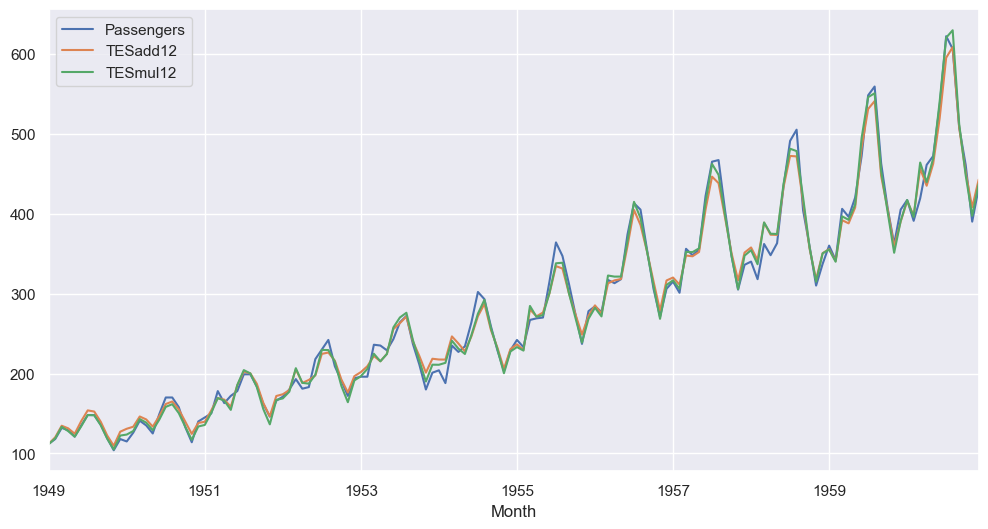

In [69]:
df_airline[['Passengers','TESadd12','TESmul12']].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

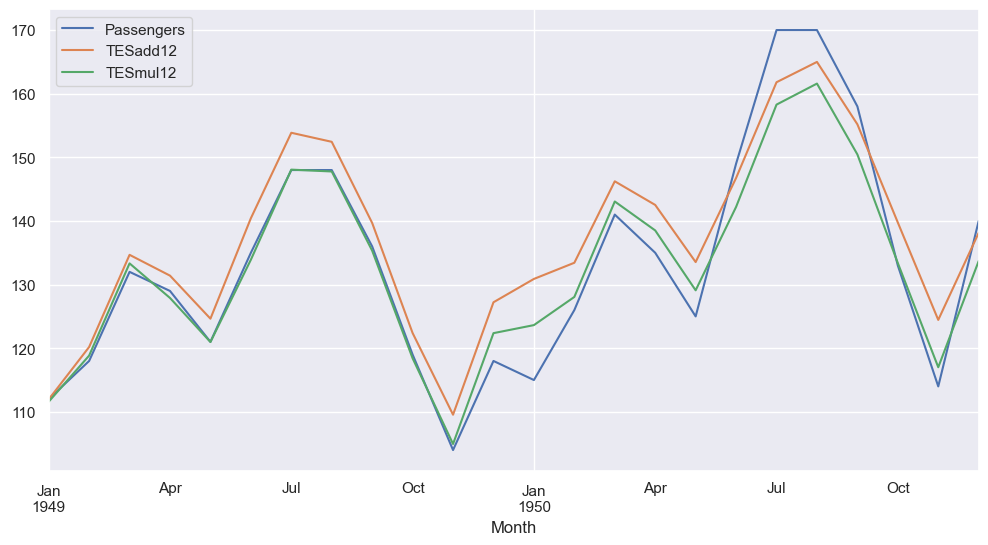

In [70]:
df_airline[['Passengers','TESadd12','TESmul12']].iloc[:24].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

# Pronósticos (Forecasting)

In [71]:
# Descomposición en conjunto de entrenamiento y conjunto de prueba
df_airline_train_data = df_airline.iloc[:108] 
df_airline_test_data = df_airline.iloc[108:]

In [72]:
# Ajuste del modelo (Exponential Smoothing)
from statsmodels.tsa.holtwinters import ExponentialSmoothing

df_airline_fitted_model = ExponentialSmoothing(df_airline_train_data['Passengers'],trend='mul',seasonal='mul',seasonal_periods=12).fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


In [73]:
# Evaluación del modelo
df_airline_test_predictions = df_airline_fitted_model.forecast(36).rename('HW Forecast')

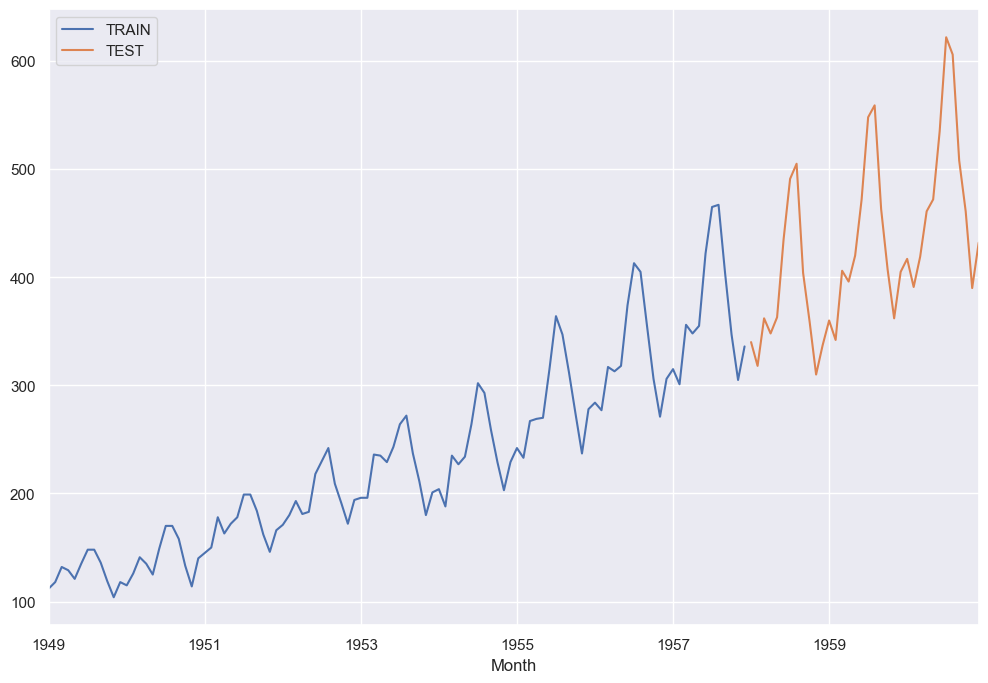

In [74]:
df_airline_train_data['Passengers'].plot(legend=True,label='TRAIN')
df_airline_test_data['Passengers'].plot(legend=True,label='TEST',figsize=(12,8));

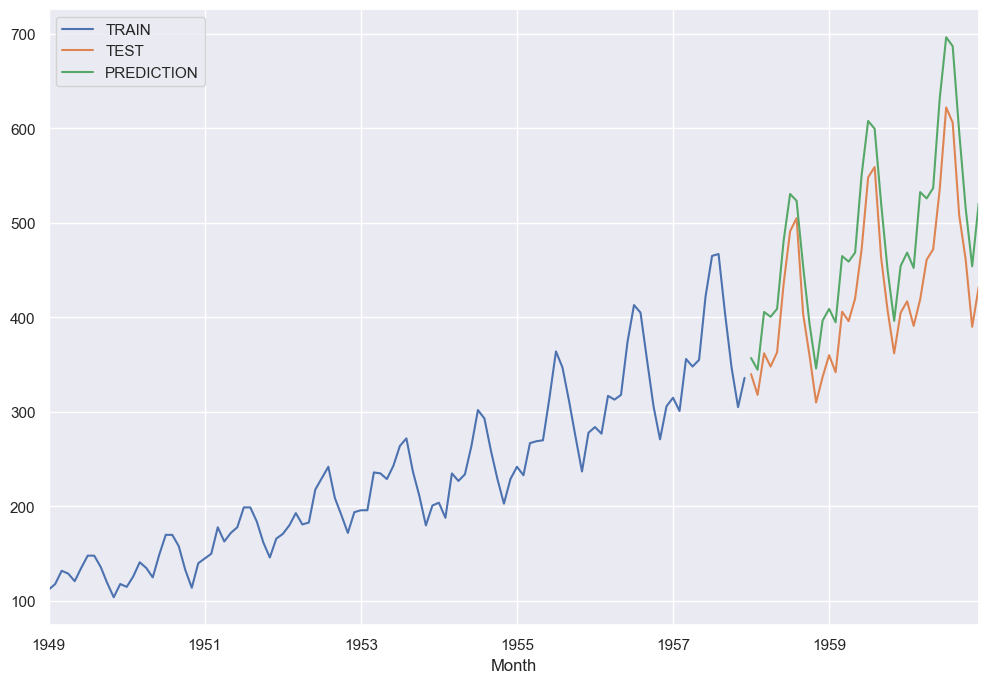

In [75]:
df_airline_train_data['Passengers'].plot(legend=True,label='TRAIN')
df_airline_test_data['Passengers'].plot(legend=True,label='TEST',figsize=(12,8))
df_airline_test_predictions.plot(legend=True,label='PREDICTION');

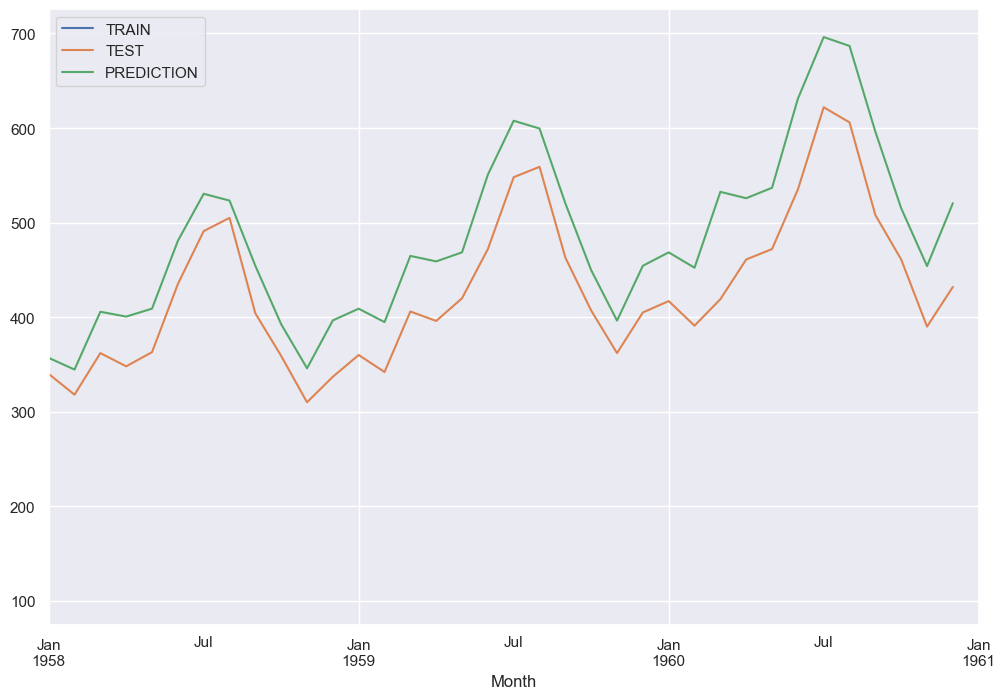

In [76]:
df_airline_train_data['Passengers'].plot(legend=True,label='TRAIN')
df_airline_test_data['Passengers'].plot(legend=True,label='TEST',figsize=(12,8))
df_airline_test_predictions.plot(legend=True,label='PREDICTION',xlim=['1958-01-01','1961-01-01']);

# Métricas de evaluación

In [77]:
from sklearn.metrics import mean_squared_error,mean_absolute_error

In [78]:
df_airline_test_data.drop(['6-month-SMA','12-month-SMA','EWMA12','SES12','DESadd12','DESmul12','TESadd12','TESmul12'], axis='columns',inplace=True)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_8900\2008869839.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_airline_test_data.drop(['6-month-SMA','12-month-SMA','EWMA12','SES12','DESadd12','DESmul12','TESadd12','TESmul12'], axis='columns',inplace=True)


In [79]:
df_airline_test_data.head()

,Passengers
Month,
1958-01-01,340
1958-02-01,318
1958-03-01,362
1958-04-01,348
1958-05-01,363


In [80]:
df_airline_test_predictions.head()

1958-01-01    356.968658
1958-02-01    344.588831
1958-03-01    405.718358
1958-04-01    400.610839
1958-05-01    409.001684
Freq: MS, Name: HW Forecast, dtype: float64

In [81]:
mean_absolute_error(df_airline_test_data,df_airline_test_predictions)

55.698326986164496

In [82]:
mean_squared_error(df_airline_test_data,df_airline_test_predictions)

3525.9322806129094

In [83]:
np.sqrt(mean_squared_error(df_airline_test_data,df_airline_test_predictions))

59.3795611352333

In [84]:
# Modelo final
final_model = ExponentialSmoothing(df_airline['Passengers'],trend='mul',seasonal='mul',seasonal_periods=12).fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


In [85]:
forecast_predictions = final_model.forecast(36)

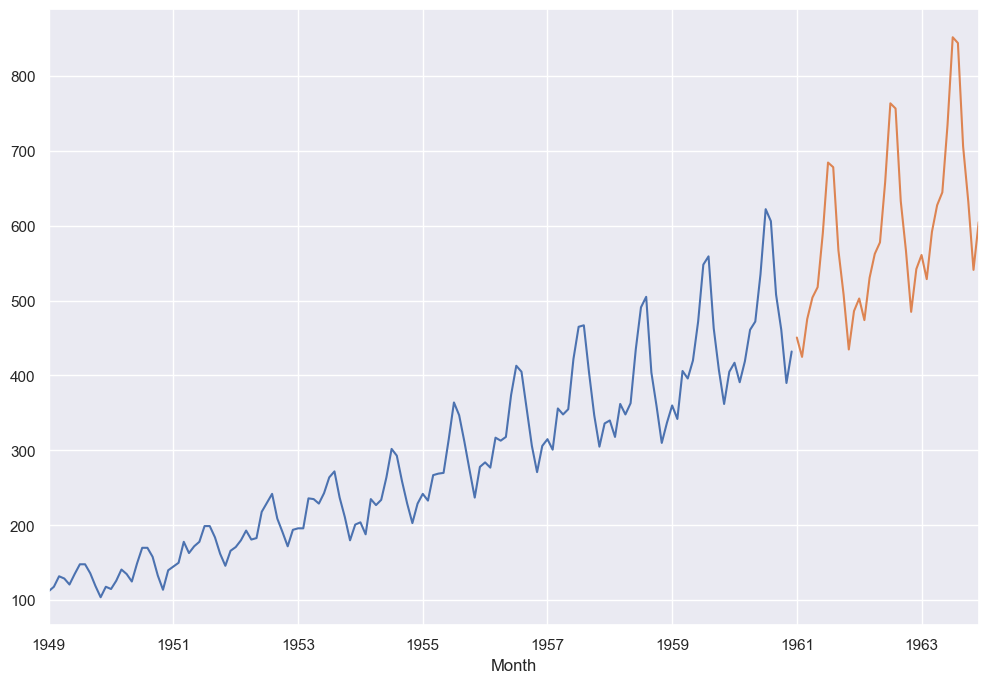

In [86]:
df_airline['Passengers'].plot(figsize=(12,8))
forecast_predictions.plot();

# Estacionaridad

In [87]:
sts.adfuller(df_yfinance['spx'])

(2.495421902147278,
 0.9990483594146493,
 32,
 7959,
 {'1%': -3.4311718884675066,
  '5%': -2.861903215555782,
  '10%': -2.566963334958385},
 72367.34132821791)

In [88]:
sts.adfuller(df_yfinance['wn'])

(-89.7224572049984,
 0.0,
 0,
 7991,
 {'1%': -3.431168596152813,
  '5%': -2.861901760790028,
  '10%': -2.5669625605706994},
 134821.61118186387)

In [89]:
sts.adfuller(df_yfinance['rw'])

(0.3500668326441943,
 0.9795284577071659,
 0,
 7991,
 {'1%': -3.431168596152813,
  '5%': -2.861901760790028,
  '10%': -2.5669625605706994},
 59204.34005517508)

In [90]:
sts.adfuller(df_ventas['Ventas'])

(-2.853928653615534,
 0.05097376463402474,
 13,
 351,
 {'1%': -3.44911857009962,
  '5%': -2.8698097654570507,
  '10%': -2.5711757061225153},
 6365.4145809406855)

# Funciones de autocorrelación y autocorrelación parcial

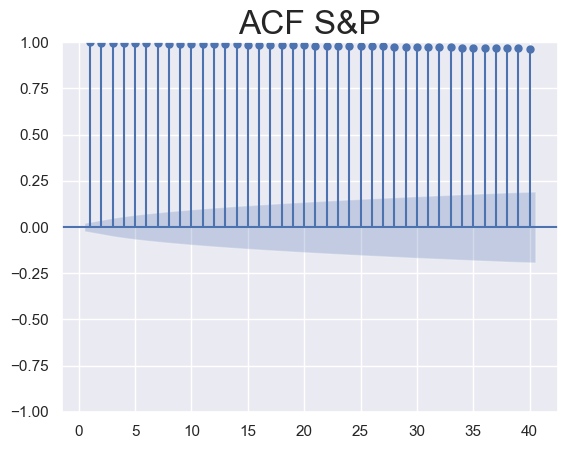

In [91]:
sgt.plot_acf(df_yfinance['spx'], lags = 40, zero = False)
plt.title("ACF S&P", size = 24)
plt.show()

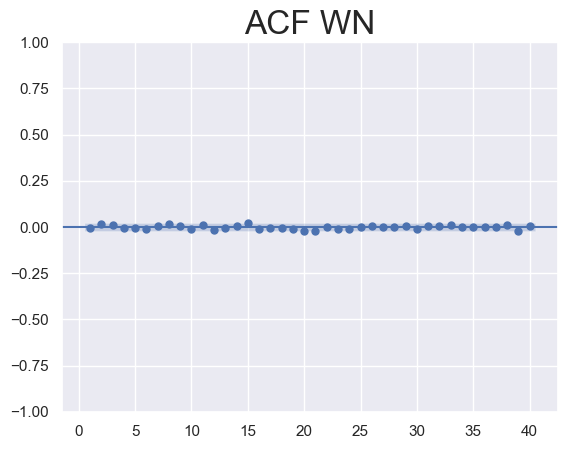

In [92]:
sgt.plot_acf(df_yfinance['wn'], lags = 40, zero = False)
plt.title("ACF WN", size = 24)
plt.show()

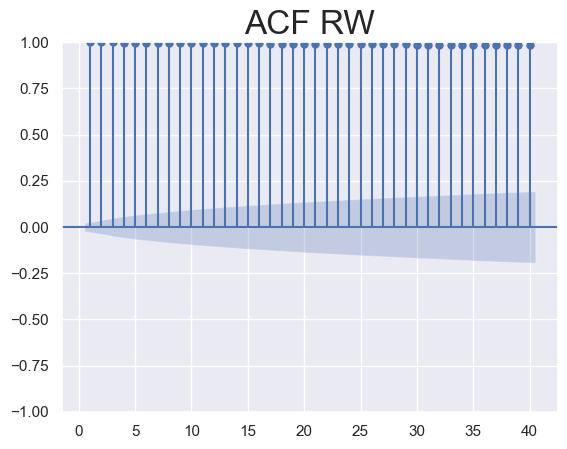

In [93]:
sgt.plot_acf(df_yfinance['rw'], lags = 40, zero = False)
plt.title("ACF RW", size = 24)
plt.show()

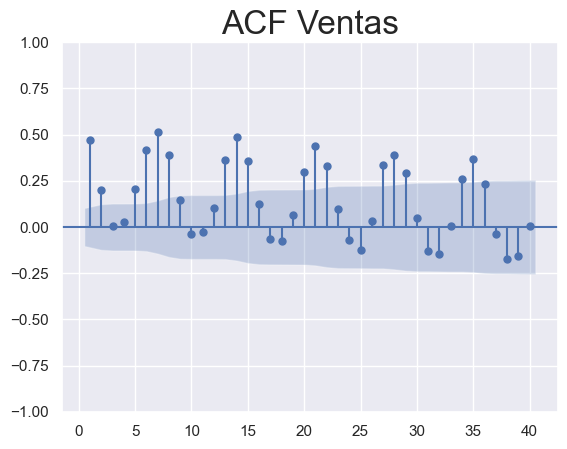

In [94]:
sgt.plot_acf(df_ventas['Ventas'], lags = 40, zero = False)
plt.title("ACF Ventas", size = 24)
plt.show()

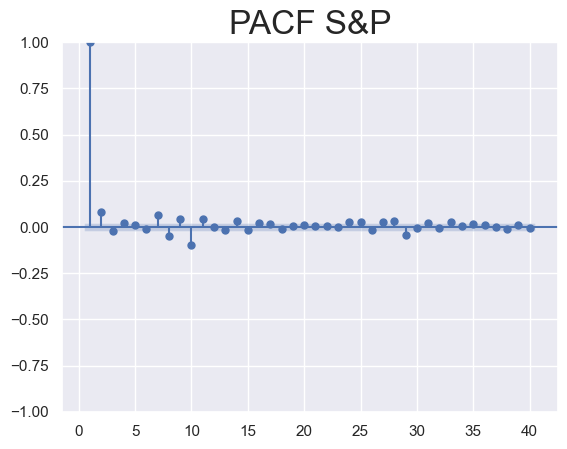

In [95]:
sgt.plot_pacf(df_yfinance['spx'], lags = 40, zero = False, method = ('ols'))
plt.title("PACF S&P", size = 24)
plt.show()

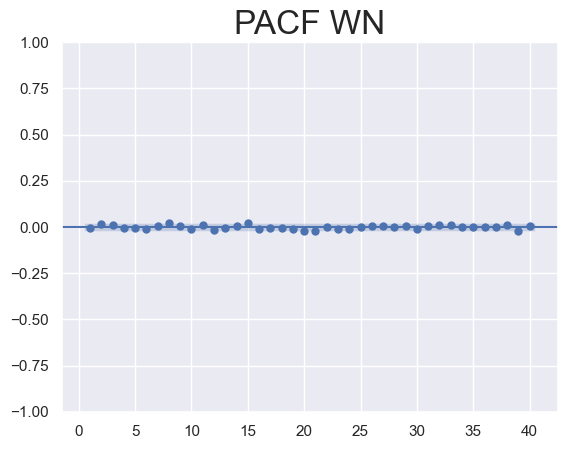

In [96]:
sgt.plot_pacf(df_yfinance['wn'], lags = 40, zero = False, method = ('ols'))
plt.title("PACF WN", size = 24)
plt.show()

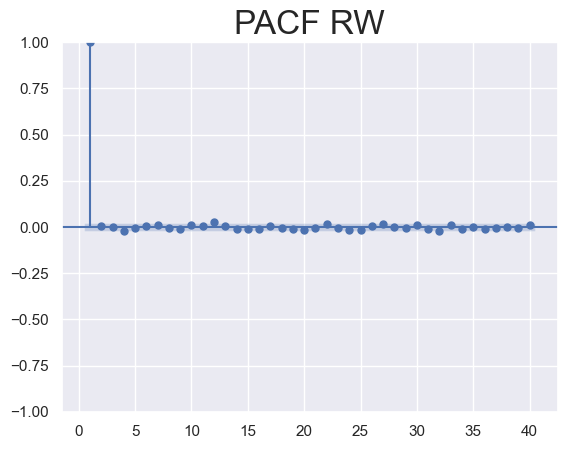

In [97]:
sgt.plot_pacf(df_yfinance['rw'], lags = 40, zero = False, method = ('ols'))
plt.title("PACF RW", size = 24)
plt.show()

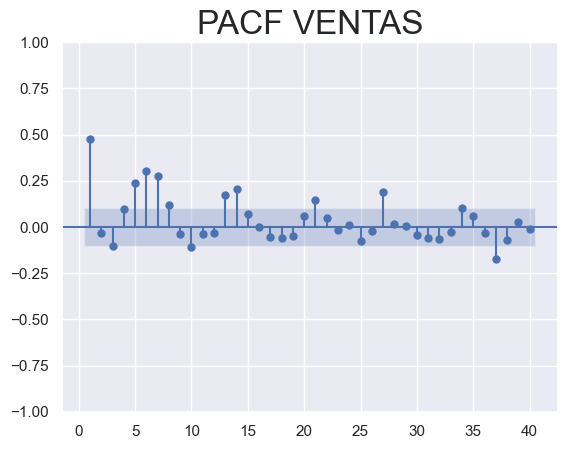

In [98]:
sgt.plot_pacf(df_ventas['Ventas'], lags = 40, zero = False, method = ('ols'))
plt.title("PACF VENTAS", size = 24)
plt.show()